In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
import pandas as pd
import time

options = webdriver.FirefoxOptions()
options.headless = True 
driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)

base_urls = {
    2024: 'https://www.worldaquatics.com/competitions/2969/world-aquatics-championships-doha-2024/results?disciplines=WP&event=34b5b78f-a3a8-460d-b237-8e52ef04400c',
    2023: 'https://www.worldaquatics.com/competitions/1/world-aquatics-championships-fukuoka-2023/results?disciplines=WP&event=d9520952-dcb7-4743-bc3e-4fe1fa05a8c2',
    2022: 'https://www.worldaquatics.com/competitions/2902/19th-fina-world-championships-budapest-2022/results?disciplines=WP&event=b548c9eb-a01e-416e-b408-21072746bffc',
    2021: 'https://www.worldaquatics.com/competitions/2409/fina-men-s-water-polo-world-league-super-final-2021/results?event=8d293c9f-7b1e-42bd-807b-ea17bfd3a322'
}

rounds = [
    'finals', 'semifinals', 'quarterfinals', 'classification', 'round-of-16', 
    'group-a', 'group-b', 'group-c', 'group-d'
]

def scrape_data(url, year, round):
    driver.get(url)
    time.sleep(5)  
    results = []
    rows = driver.find_elements(By.CSS_SELECTOR, 'tr.results-table__row')
    for row in rows:
        cells = row.find_elements(By.CSS_SELECTOR, 'td')
        if len(cells) > 6:
            match_info = cells[1].text
            date_time = cells[2].text + ' ' + cells[3].text
            countries = ' vs '.join([div.text for div in cells[4].find_elements(By.CSS_SELECTOR, 'div.results-table__country')])
            scores = ' '.join([span.text for span in cells[5].find_elements(By.CSS_SELECTOR, 'span.results-table__score')])
            final_score = cells[7].text
            results.append({
                'Year': year,
                'Round': round,
                'Match Info': match_info,
                'Date Time': date_time,
                'Countries': countries,
                'Scores by Quarter': scores,
                'Final Score': final_score
            })
    return results

all_data = []
for year, base_url in base_urls.items():
    for round in rounds:
        full_url = f'{base_url}&unit={round}'
        try:
            data = scrape_data(full_url, year, round)
            all_data.extend(data)
        except Exception as e:
            print(f"Error scraping {full_url}: {e}")

df = pd.DataFrame(all_data)
df.to_csv('water_polo_results_selenium.csv', index=False)

driver.quit()

print('Data scraping complete and saved to water_polo_results_selenium.csv.')


Data scraping complete and saved to water_polo_results_selenium.csv.


In [14]:
import pandas as pd
import numpy as np

In [15]:
df = pd.read_csv('water_polo_results_selenium.csv')
df

,Year,Round,Match Info,Date Time,Countries,Scores by Quarter,Final Score
0,2024,finals,Men's Placement Match 3/4\nOFFICIAL,2/17/2024 3:30,Spain vs France,4 1 5 3 2 2 3 4,14\n10
1,2024,finals,Men's Final Match 48\nOFFICIAL,2/17/2024 9:30,Italy vs Croatia,3 2 2 3 2 3 4 3,13\n15
2,2024,semifinals,Men's Semi Final Match 43\nOFFICIAL,2/15/2024 8:00,Spain vs Italy,1 1 1 3 1 2 3 2,6\n8
3,2024,semifinals,Men's Semi Final Match 44\nOFFICIAL,2/15/2024 9:30,Croatia vs France,3 2 3 3 3 1 2 5,17\n16
4,2024,quarterfinals,Men's Quarter Final Round Match 35\nOFFICIAL,2/13/2024 8:00,Spain vs Montenegro,5 2 3 5 5 0 2 5,15\n12
...,...,...,...,...,...,...,...
142,2021,group-b,Group B Match 2\nOFFICIAL,6/26/2021 8:30,Japan vs Georgia,3 3 2 4 6 5 1 1,12\n13
143,2021,group-b,Group A Match 3\nOFFICIAL,6/27/2021 8:30,Georgia vs Montenegro,2 8 4 6 1 3 1 2,8\n19
144,2021,group-b,Group B Match 4\nOFFICIAL,6/27/2021 12:00,Japan vs United States of America,2 3 2 4 2 3 1 5,7\n15
145,2021,group-b,Group B Match 6\nOFFICIAL,6/28/2021 8:30,United States of America vs Georgia,3 1 5 2 2 3 3 3,13\n9


In [26]:
def team_split(s):
    s=str(s)
    spl=s.split(' vs ')
    return spl[0], spl[1]

def score_split(s):
    s=str(s)
    spl=s.split('\n')
    return spl[0], spl[1]

def querter_split(s):
    s=str(s)
    spl=s.split(' ')
    return spl[0]+spl[2]+spl[4]+spl[6],spl[1]+spl[3]+spl[5]+spl[7]

In [27]:

df['Team1'], df['Team2'] = zip(*df['Countries'].map(team_split))
df['Score1'], df['Score2'] = zip(*df['Final Score'].map(score_split))

df['weight']=0

for i in range(len(df)):
    if int(df['Score1'][i])>int(df['Score2'][i]):
        df['weight'][i]=1+np.log(int(df['Score1'][i])-int(df['Score2'][i])/int(df['Score1'][i]) )
    else:
        df['weight'][i]=1+np.log(int(df['Score2'][i])-int(df['Score1'][i])/int(df['Score2'][i]) )


C:\Users\leona\AppData\Local\Temp\ipykernel_7372\337409906.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'][i]=1+np.log(int(df['Score1'][i])-int(df['Score2'][i])/int(df['Score1'][i]) )


In [28]:
df

,Year,Round,Match Info,Date Time,Countries,Scores by Quarter,Final Score,Team1,Team2,Score1,Score2,weight
0,2024,finals,Men's Placement Match 3/4\nOFFICIAL,2/17/2024 3:30,Spain vs France,4 1 5 3 2 2 3 4,14\n10,Spain,France,14,10,3.586689
1,2024,finals,Men's Final Match 48\nOFFICIAL,2/17/2024 9:30,Italy vs Croatia,3 2 2 3 2 3 4 3,13\n15,Italy,Croatia,13,15,3.648536
2,2024,semifinals,Men's Semi Final Match 43\nOFFICIAL,2/15/2024 8:00,Spain vs Italy,1 1 1 3 1 2 3 2,6\n8,Spain,Italy,6,8,2.981001
3,2024,semifinals,Men's Semi Final Match 44\nOFFICIAL,2/15/2024 9:30,Croatia vs France,3 2 3 3 3 1 2 5,17\n16,Croatia,France,17,16,3.776258
4,2024,quarterfinals,Men's Quarter Final Round Match 35\nOFFICIAL,2/13/2024 8:00,Spain vs Montenegro,5 2 3 5 5 0 2 5,15\n12,Spain,Montenegro,15,12,3.653242
...,...,...,...,...,...,...,...,...,...,...,...,...
142,2021,group-b,Group B Match 2\nOFFICIAL,6/26/2021 8:30,Japan vs Georgia,3 3 2 4 6 5 1 1,12\n13,Japan,Georgia,12,13,3.491296
143,2021,group-b,Group A Match 3\nOFFICIAL,6/27/2021 8:30,Georgia vs Montenegro,2 8 4 6 1 3 1 2,8\n19,Georgia,Montenegro,8,19,3.922029
144,2021,group-b,Group B Match 4\nOFFICIAL,6/27/2021 12:00,Japan vs United States of America,2 3 2 4 2 3 1 5,7\n15,Japan,United States of America,7,15,3.676445
145,2021,group-b,Group B Match 6\nOFFICIAL,6/28/2021 8:30,United States of America vs Georgia,3 1 5 2 2 3 3 3,13\n9,United States of America,Georgia,13,9,3.510224


In [29]:
teams=df['Team1'].unique()

C:\Users\leona\AppData\Local\Temp\ipykernel_7372\3866552297.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games = games.append({'TeamA':teamA,'TeamB':teamB,'Games':gamesA},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7372\3866552297.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games = games.append({'TeamA':teamB,'TeamB':teamA,'Games':gamesA},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7372\3866552297.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games = games.append({'TeamA':teamA,'TeamB':teamB,'Games':gamesA},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7372\3866552297.py:15: FutureWarning: The frame.append method is deprecated and will be removed

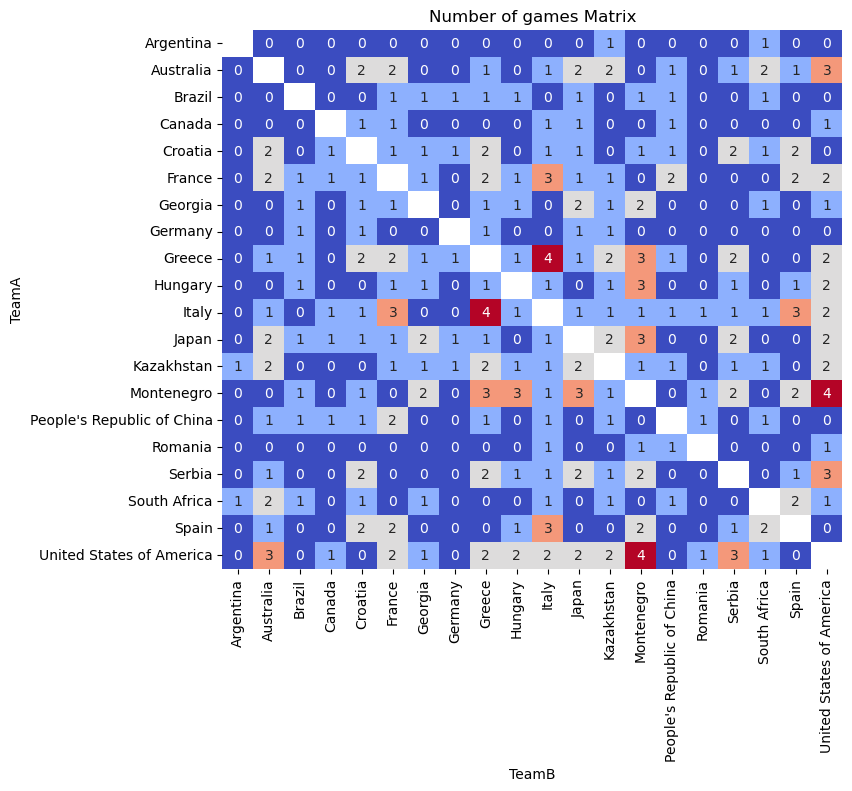

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.DataFrame(columns=['TeamA','TeamB','Games'])

for i in range(len(teams)):
    for j in range(len(teams)):
        if i==j :
            continue
        teamA = teams[i]
        teamB = teams[j]
        gamesA = df[((df['Team1']==teamA) & (df['Team2']==teamB))|((df['Team1']==teamB) & (df['Team2']==teamA))]
        gamesA = len(gamesA)
        games = games.append({'TeamA':teamA,'TeamB':teamB,'Games':gamesA},ignore_index=True)
        games = games.append({'TeamA':teamB,'TeamB':teamA,'Games':gamesA},ignore_index=True)

games_matrix = pd.pivot_table(games, values='Games', index='TeamA', columns='TeamB')
plt.figure(figsize=(8, 7))
sns.heatmap(games_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Number of games Matrix')
plt.show()



In [31]:
teams = df['Team1'].unique()

probs = pd.DataFrame(columns=['TeamA','TeamB','Prob'])

for i in range(len(teams)):
    for j in range(i+1,len(teams)):
        teamA = teams[i]
        teamB = teams[j]

        if len(df[((df['Team1']==teamA) & (df['Team2']==teamB))|((df['Team1']==teamB) & (df['Team2']==teamA))])==0:
            continue

        
        gamesA = df[ ((df['Team1']==teamA) | (df['Team2']==teamA)) & (df['Score1']>df['Score2'])]
        gamesB = df[ ((df['Team1']==teamB) | (df['Team2']==teamB)) & (df['Score1']<df['Score2'])]
        gamesA = gamesA['weight'].sum()
        gamesB = gamesB['weight'].sum()
        if gamesA+gamesB<1e-7:
            probs=0.5
        else:
            prob = gamesA/(gamesA+gamesB)
        probs = probs.append({'TeamA':teamA,'TeamB':teamB,'Prob':prob},ignore_index=True)
        probs = probs.append({'TeamA':teamB,'TeamB':teamA,'Prob':1-prob},ignore_index=True)

probs


C:\Users\leona\AppData\Local\Temp\ipykernel_7372\1745014825.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'TeamA':teamA,'TeamB':teamB,'Prob':prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7372\1745014825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'TeamA':teamB,'TeamB':teamA,'Prob':1-prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7372\1745014825.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'TeamA':teamA,'TeamB':teamB,'Prob':prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7372\1745014825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from p

,TeamA,TeamB,Prob
0,Spain,Italy,0.333304
1,Italy,Spain,0.666696
2,Spain,Croatia,0.440311
3,Croatia,Spain,0.559689
4,Spain,Serbia,0.440581
...,...,...,...
197,Argentina,Kazakhstan,0.141678
198,Kazakhstan,Germany,0.607612
199,Germany,Kazakhstan,0.392388
200,Kazakhstan,Georgia,0.500522


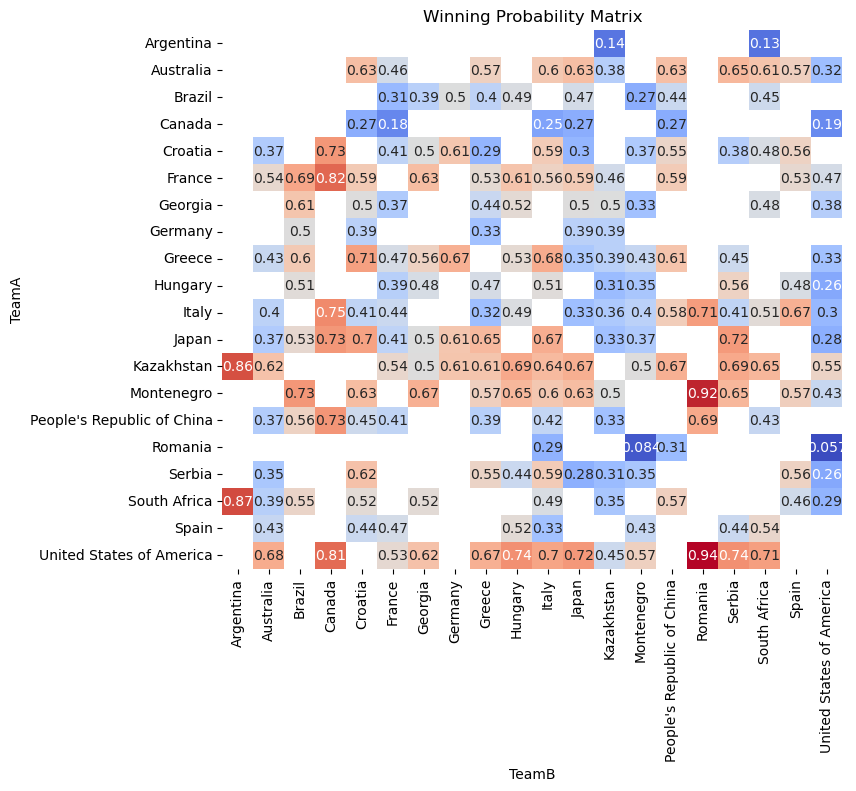

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

probs_matrix = pd.pivot_table(probs, values='Prob', index='TeamA', columns='TeamB')
plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix')
plt.show()



In [33]:
gamesA = df[((df['Team1']=='Croatia') & (df['Team2']=='Georgia'))|((df['Team1']=='Georgia') & (df['Team2']=='Croatia'))]
gamesA

,Year,Round,Match Info,Date Time,Countries,Scores by Quarter,Final Score,Team1,Team2,Score1,Score2,weight
99,2022,round-of-16,Men's Preliminary Round II Match 28\nOFFICIAL,6/27/2022 9:30,Georgia vs Croatia,2 3 2 4 0 3 3 3,7\n13,Georgia,Croatia,7,13,3.522647


In [34]:
gamesA = df[((df['Team1']=='South Africa') & (df['Team2']=='Argentina'))|((df['Team1']=='Argentina') & (df['Team2']=='South Africa'))]
gamesA

,Year,Round,Match Info,Date Time,Countries,Scores by Quarter,Final Score,Team1,Team2,Score1,Score2,weight
53,2023,classification,Men's Classification 13-16 Match 26\nOFFICIAL,7/22/2023 21:30,Argentina vs South Africa,3 0 4 2 5 1 3 3,15\n6,Argentina,South Africa,15,6,3.681022


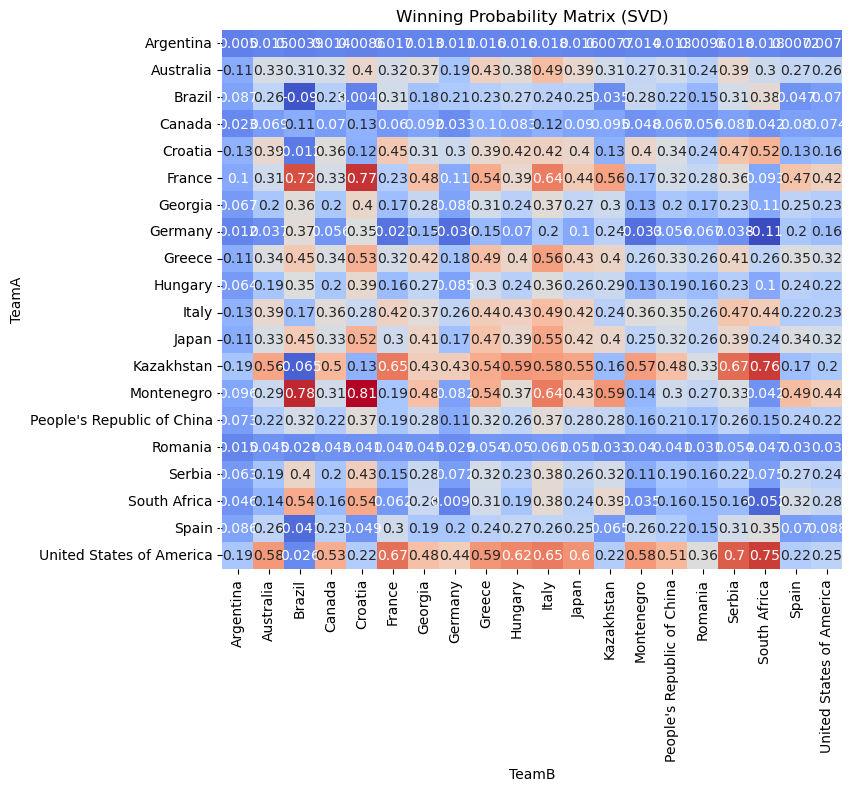

In [35]:
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

probs_matrix = pd.pivot_table(probs, values='Prob', index='TeamA', columns='TeamB')
probs_matrix = probs_matrix.fillna(0)
U, S, Vt = svds(csc_matrix(probs_matrix), k=2)
S = np.diag(S)
probs_matrix_svd = np.dot(np.dot(U, S), Vt)
probs_matrix_svd = pd.DataFrame(probs_matrix_svd, index=probs_matrix.index, columns=probs_matrix.columns)

plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix_svd, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix (SVD)')
plt.show()

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.Graph()

won={}
los={}

for i in range(len(df)):
    team1, team2 = team_split(df['Countries'][i])
    score1, score2 = score_split(df['Final Score'][i])

    won[team1]=won.get(team1,0)+int(score1>score2)
    los[team1]=los.get(team1,0)+int(score1<score2)
    
    if team1 not in G.nodes:
        G.add_node(team1)
    if team2 not in G.nodes:
        G.add_node(team2)
    
    if G.has_edge(team1, team2):
        G[team1][team2]['weight'] += 1
    else:
        G.add_edge(team1, team2, weight=1)  

nx.write_gexf(G, 'water_polo_results_selenium.gexf')



In [37]:
print(won)
print(los)

{'Spain': 5, 'Italy': 2, 'Croatia': 2, 'Greece': 4, 'Serbia': 3, 'Hungary': 4, 'South Africa': 5, 'Japan': 3, 'Brazil': 3, "People's Republic of China": 4, 'Australia': 5, 'Romania': 1, 'Montenegro': 6, 'United States of America': 1, 'France': 3, 'Kazakhstan': 5, 'Argentina': 0, 'Canada': 2, 'Germany': 0, 'Georgia': 4}
{'Spain': 3, 'Italy': 8, 'Croatia': 4, 'Greece': 12, 'Serbia': 4, 'Hungary': 4, 'South Africa': 1, 'Japan': 6, 'Brazil': 3, "People's Republic of China": 2, 'Australia': 5, 'Romania': 1, 'Montenegro': 7, 'United States of America': 10, 'France': 3, 'Kazakhstan': 5, 'Argentina': 1, 'Canada': 1, 'Germany': 2, 'Georgia': 2}


In [40]:
# Real Data
MENS_POOLS={'A':['Croatia','Italy','Romania','United States of America','Greece','Montenegro'],
            'B':['France','Hungary','Spain','Serbia','Australia','Japan']}


In [42]:

def simulate_match(team1, team2, probs_matrix):
    prob_team1_wins = probs_matrix.loc[team1, team2]
    return team1 if np.random.rand() < prob_team1_wins else team2

def simulate_group_stage(teams, probs_matrix):
    points = {team: 0 for team in teams}
    for i, team1 in enumerate(teams):
        for j, team2 in enumerate(teams):
            if i < j:
                winner = simulate_match(team1, team2, probs_matrix)
                points[winner] += 2
    return points

def rank_teams(points):
    return sorted(points.items(), key=lambda x: (-x[1], x[0]))

def simulate_knockout_stage(teams, probs_matrix):
    winners = []
    for i in range(0, len(teams), 2):
        winner = simulate_match(teams[i], teams[i+1], probs_matrix)
        winners.append(winner)
    return winners

def simulate_tournament(MENS_POOLS, probs_matrix):
    group_results = {}
    for group, teams in MENS_POOLS.items():
        points = simulate_group_stage(teams, probs_matrix)
        ranked_teams = rank_teams(points)
        group_results[group] = [team for team, _ in ranked_teams]
    
    quarter_finalists_A = group_results['A'][:4]
    quarter_finalists_B = group_results['B'][:4]

    # Cuartos de final cruzados
    quarter_finals = [
        (quarter_finalists_A[0], quarter_finalists_B[3]),
        (quarter_finalists_A[1], quarter_finalists_B[2]),
        (quarter_finalists_A[2], quarter_finalists_B[1]),
        (quarter_finalists_A[3], quarter_finalists_B[0]),
    ]
    
    quarter_final_winners = []
    for match in quarter_finals:
        winner = simulate_match(match[0], match[1], probs_matrix)
        quarter_final_winners.append(winner)
    
    # Semifinales
    semi_finals = [
        (quarter_final_winners[0], quarter_final_winners[1]),
        (quarter_final_winners[2], quarter_final_winners[3]),
    ]
    
    semi_final_winners = []
    semi_final_losers = []
    for match in semi_finals:
        winner = simulate_match(match[0], match[1], probs_matrix)
        loser = match[0] if winner == match[1] else match[1]
        semi_final_winners.append(winner)
        semi_final_losers.append(loser)
    
    # Final
    gold_medal_winner = simulate_match(semi_final_winners[0], semi_final_winners[1], probs_matrix)
    silver_medal_winner = semi_final_winners[1] if gold_medal_winner == semi_final_winners[0] else semi_final_winners[0]
    
    # Partido por el bronce
    bronze_medal_winner = simulate_match(semi_final_losers[0], semi_final_losers[1], probs_matrix)
    
    return {
        'gold_medal_winner': gold_medal_winner,
        'silver_medal_winner': silver_medal_winner,
        'bronze_medal_winner': bronze_medal_winner
    }

# Simular el torneo
tournament_results = simulate_tournament(MENS_POOLS, probs_matrix_svd)

print(tournament_results)

{'gold_medal_winner': 'Croatia', 'silver_medal_winner': 'Spain', 'bronze_medal_winner': 'Hungary'}
